# **Tutorial: Convolutional-Recurrent Neural Networks for WikiArt Classification**

# **EfficientNetV2-S + ConvLSTM + Self-Attention**

Implementing a Convolutional-Recurrent Neural Network (CRNN) using EfficientNetV2-S as the backbone, combined with ConvLSTM and Self-Attention, to classify artwork from the WikiArt dataset.

This model is designed to capture both spatial and temporal features, leveraging:
* EfficientNetV2-S for feature extraction
* ConvLSTM for sequential dependencies
* Self-Attention for refined feature representation
* Feature Pyramid Network (FPN) for multi-scale feature fusion
* Label Smoothing & Dropout (0.4) for regularization

In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Reshape, Attention, ConvLSTM2D, BatchNormalization, Add, Concatenate
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

from utils.dataset_utils import *
from models.crn import *


# **Dataset Preparation**

In [7]:

# Path to the folder containing csv files (ie. wikiart_csv)
csv_folder_path = "/kaggle/input/wikiart-csv/wikiart_csv"
# Path to the folder containing  images from wikiart (ie. wikiart)
image_folder_path = "/kaggle/input/wikiart"
# Path to save a new csv file containing all the information about  dataset
csv_output_path = "/kaggle/working/"

data = get_data(csv_folder_path, 
                          image_folder_path, 
                          csv_output_path=csv_output_path)
data.shape


<ipython-input-3-675a41d3ff52>:286: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv(os.path.join(chan_csv_folder_path, target + "_class.txt"),
<ipython-input-3-675a41d3ff52>:286: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv(os.path.join(chan_csv_folder_path, target + "_class.txt"),
<ipython-input-3-675a41d3ff52>:286: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv(os.path.join(chan_csv_folder_path, target + "_class.txt"),


(78746, 10)

# **8 styles chosen to be used**

In [8]:

# Dictionary used to merge or drop some classes
merge={'name': 'style_m1',
       'merging':{'abstract_expressionism': 'abstract', 'action_painting': 'abstract', 
                  'analytical_cubism': 'cubism', 'art_nouveau_modern': None, 'baroque': None, 
                  'color_field_painting': 'color_field_painting', 'contemporary_realism': None, 
                  'cubism': 'cubism', 'early_renaissance': 'renaissance', 
                  'expressionism': 'expressionism', 'fauvism': None, 'high_renaissance': 'renaissance', 
                  'impressionism': 'impressionism', 'mannerism_late_renaissance': None, 
                  'minimalism': None, 'naive_art_primitivism': None, 'new_realism': None, 
                  'northern_renaissance': 'renaissance', 'pointillism': None, 'pop_art': None,
                  'post_impressionism': None, 'realism': 'realism', 'rococo': None, 
                  'romanticism': 'romanticism', 'symbolism': None, 'synthetic_cubism': 'cubism', 
                  'ukiyo_e': None}}

# Path to save a new csv file containing all the information about the new dataset
csv_file_name =  "/kaggle/working/wikiart-target_style-class_27.csv"
# Path to create a new directory containing all the wikiart images used in the new dataset
image_folder_output_path = "/kaggle/working"

flat=False


# Train, Val, and test ratio to split the new dataset
val_ratio=0.1
test_ratio=0.1

data=create_dataset(csv_file_name, 
                    merge=merge, 
                    random_state=123,
                    image_folder_path=image_folder_path, 
                    csv_output_path=csv_output_path, 
                    image_folder_output_path=image_folder_output_path,
                    val_ratio=val_ratio,
                    test_ratio=test_ratio)

2500 images copied
5000 images copied
7500 images copied
10000 images copied
12500 images copied
15000 images copied
17500 images copied
20000 images copied
22500 images copied
25000 images copied
27500 images copied
30000 images copied
32500 images copied
35000 images copied
37500 images copied
40000 images copied
Done: 40800 image(s) copied


# **Classes chosen**

In [ ]:
CLASS_NAMES = [
    'abstract', 
    'cubism', 
    'color_field_painting', 
    'renaissance', 
    'expressionism', 
    'impressionism', 
    'realism', 
    'romanticism'
]

# **Model Training**


Found 32640 files belonging to 8 classes.
Found 4080 files belonging to 8 classes.
Found 4080 files belonging to 8 classes.
Epoch 1/50
2040/2040 ━━━━━━━━━━━━━━━━━━━━ 676s 296ms/step - accuracy: 0.4766 - loss: 1.5357 - val_accuracy: 0.6806 - val_loss: 1.1222
Epoch 2/50
2040/2040 ━━━━━━━━━━━━━━━━━━━━ 596s 292ms/step - accuracy: 0.6270 - loss: 1.2527 - val_accuracy: 0.7132 - val_loss: 1.0739
Epoch 3/50
2040/2040 ━━━━━━━━━━━━━━━━━━━━ 595s 291ms/step - accuracy: 0.6629 - loss: 1.1873 - val_accuracy: 0.7098 - val_loss: 1.0736
Epoch 4/50
2040/2040 ━━━━━━━━━━━━━━━━━━━━ 596s 292ms/step - accuracy: 0.6829 - loss: 1.1443 - val_accuracy: 0.7294 - val_loss: 1.0233
Epoch 5/50
2040/2040 ━━━━━━━━━━━━━━━━━━━━ 594s 291ms/step - accuracy: 0.6963 - loss: 1.1089 - val_accuracy: 0.7088 - val_loss: 1.0763
Epoch 6/50
2040/2040 ━━━━━━━━━━━━━━━━━━━━ 622s 291ms/step - accuracy: 0.7057 - loss: 1.0841 - val_accuracy: 0.7208 - val_loss: 1.0699
Epoch 7/50
2040/2040 ━━━━━━━━━━━━━━━━━━━━ 594s 291ms/step - accuracy: 0.

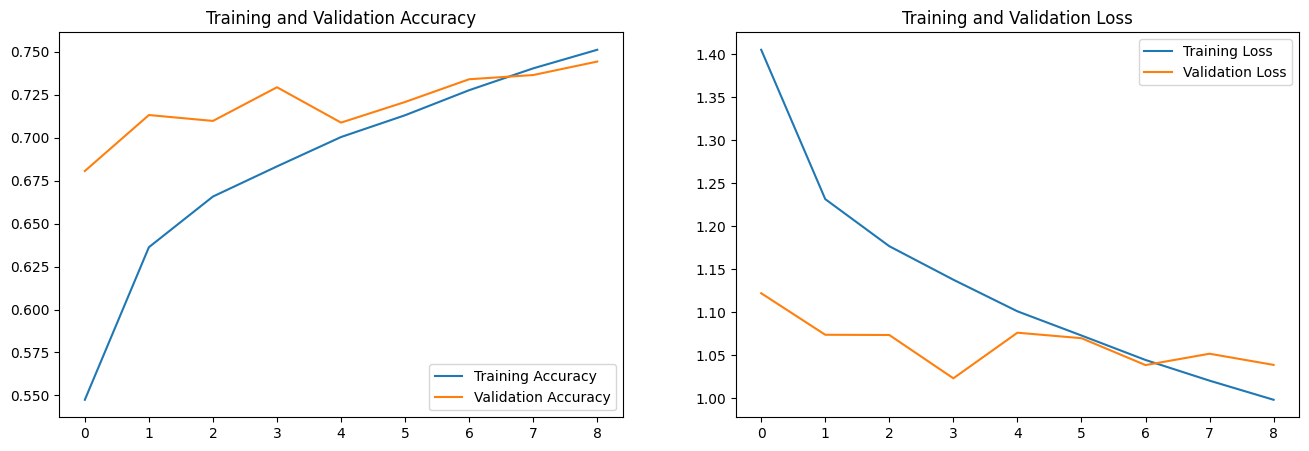

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import os
import datetime
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers.schedules import CosineDecay
from model import build_model  # Import the model function

# Enable mixed precision for better GPU memory usage
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# GPU Memory Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Dataset Paths
TRAIN_DIR = "/kaggle/input/images-8classes/wikiart-target_style-class_8-keepgenre_True-merge_style_m1-flat_False/train"
VAL_DIR = "/kaggle/input/images-8classes/wikiart-target_style-class_8-keepgenre_True-merge_style_m1-flat_False/val"
TEST_DIR = "/kaggle/input/images-8classes/wikiart-target_style-class_8-keepgenre_True-merge_style_m1-flat_False/test"

# Hyperparameters
BATCH_SIZE = 16
EPOCHS = 50
IMG_HEIGHT, IMG_WIDTH = 300, 300
NUM_CLASSES = 8

# Load Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=TRAIN_DIR, labels='inferred', image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE, label_mode='categorical', shuffle=True)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=VAL_DIR, labels='inferred', image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE, label_mode='categorical')

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=TEST_DIR, labels='inferred', image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE, label_mode='categorical')

# Dataset Optimization
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

# Load Model
model = build_model(IMG_HEIGHT, IMG_WIDTH, NUM_CLASSES)

# **Loss & Optimizer**
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)
initial_learning_rate = 1e-4
total_images_count = sum(1 for _ in train_ds) * BATCH_SIZE
lr_schedule = CosineDecay(
    initial_learning_rate, 
    decay_steps=EPOCHS * (total_images_count // BATCH_SIZE),
    alpha=0.1
)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss=loss, metrics=['accuracy'])

# Learning Rate Callback
def lr_callback(epoch, lr):
    return lr_schedule(epoch)
lr_scheduler = LearningRateScheduler(lr_callback, verbose=1)

# Callbacks
log_dir = "/kaggle/working/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
tsboard = TensorBoard(log_dir=log_dir, histogram_freq=1)
checkpoint = ModelCheckpoint(filepath="/kaggle/working/models/EfficientNet/checkpoint.weights.h5",
                              save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True)

# Train Model
history = model.fit(
    train_ds, epochs=EPOCHS, validation_data=val_ds,
    callbacks=[es, tsboard, checkpoint, lr_scheduler])

# **Plot Training History**
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


# **Evaluation**

# **Test Accuracy**

In [5]:
# Evaluate on Test Data
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


255/255 ━━━━━━━━━━━━━━━━━━━━ 45s 138ms/step - accuracy: 0.7145 - loss: 0.8027
Test Accuracy: 71.30%


In [20]:
# Get Predictions
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Get True Labels
y_true = np.concatenate([np.argmax(y, axis=1) for x, y in test_ds])

# Print Shape Check
print(f"Shape of Predictions: {y_pred.shape}, Shape of True Labels: {y_true.shape}")

# Map predictions and true labels to class names
y_pred_class_names = [CLASS_NAMES[i] for i in y_pred]
y_true_class_names = [CLASS_NAMES[i] for i in y_true]

# Example: Print first 10 predictions with their corresponding class names
for i in range(10):
    print(f"Prediction: {y_pred_class_names[i]}, True Label: {y_true_class_names[i]}")


255/255 ━━━━━━━━━━━━━━━━━━━━ 38s 148ms/step
Shape of Predictions: (4080,), Shape of True Labels: (4080,)
Prediction: renaissance, True Label: impressionism
Prediction: abstract, True Label: impressionism
Prediction: color_field_painting, True Label: expressionism
Prediction: realism, True Label: renaissance
Prediction: color_field_painting, True Label: impressionism
Prediction: abstract, True Label: color_field_painting
Prediction: expressionism, True Label: expressionism
Prediction: abstract, True Label: abstract
Prediction: impressionism, True Label: expressionism
Prediction: cubism, True Label: impressionism


In [12]:
# Check shapes after extracting
print(f"Shape of Predictions: {y_pred.shape}, Shape of True Labels: {y_true.shape}")

assert y_pred.shape == y_true.shape, "Shape mismatch between predictions and true labels!"


Shape of Predictions: (4080,), Shape of True Labels: (4080,)


# **Evaluation metrics: Confusion matrix, Precision, Recall, Precision**

In [11]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Classification Report
class_report = classification_report(y_true, y_pred, target_names=[f"Class_{i}" for i in range(NUM_CLASSES)])
print("Classification Report:\n", class_report)


Confusion Matrix:
 [[ 21  14  10  26  52  53  29  33]
 [ 12   3   9  17  36  29  15  23]
 [  9   6  13  29  42  40  20  24]
 [ 43  14  26  47 123 122  44  73]
 [ 79  48  65 131 283 242 122 149]
 [ 81  35  64 110 227 198 107 104]
 [ 32  16  22  59 103 121  48  59]
 [ 45  11  31  74 119 109  61  68]]
Classification Report:
               precision    recall  f1-score   support

     Class_0       0.07      0.09      0.07       238
     Class_1       0.02      0.02      0.02       144
     Class_2       0.05      0.07      0.06       183
     Class_3       0.10      0.10      0.10       492
     Class_4       0.29      0.25      0.27      1119
     Class_5       0.22      0.21      0.22       926
     Class_6       0.11      0.10      0.11       460
     Class_7       0.13      0.13      0.13       518

    accuracy                           0.17      4080
   macro avg       0.12      0.12      0.12      4080
weighted avg       0.17      0.17      0.17      4080



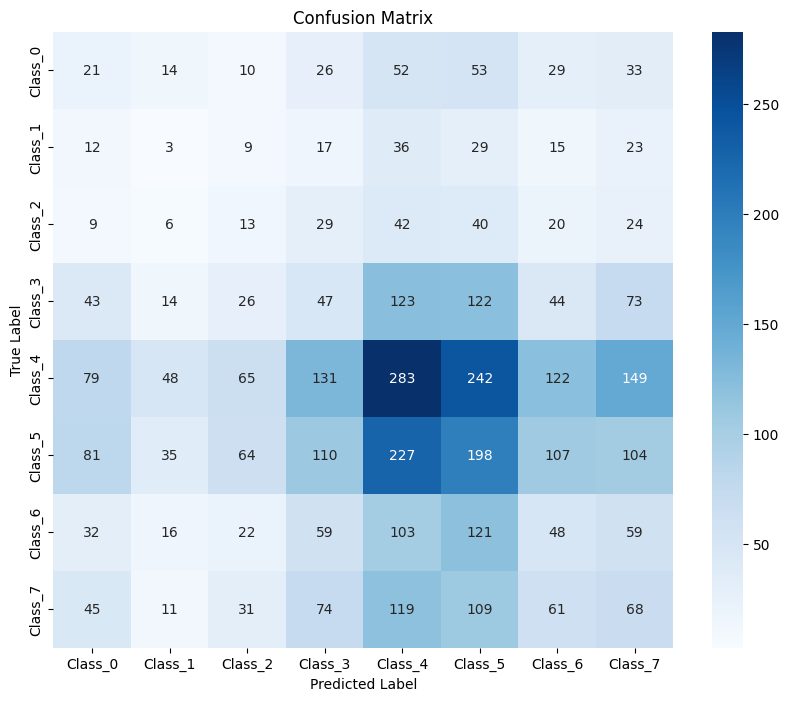

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[f"Class_{i}" for i in range(NUM_CLASSES)],
            yticklabels=[f"Class_{i}" for i in range(NUM_CLASSES)])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [14]:
# Calculate Precision, Recall, and F1 Score
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


Precision: 0.1747
Recall: 0.1669
F1-Score: 0.1704


# **Visualising Style Prediction**

In [23]:
#efficient net b0- test
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt


# Load and preprocess an image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = preprocess_input(img_array)
    return img_array

# Predict on a single image
def predict_image(img_path):
    img_array = preprocess_image(img_path)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]
    confidence = np.max(predictions)

    # Plot the image
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {CLASS_NAMES[predicted_class]} \nConfidence: {confidence:.2f}")
    plt.show()

    return CLASS_NAMES[predicted_class], confidence

# **Correct Predictions**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


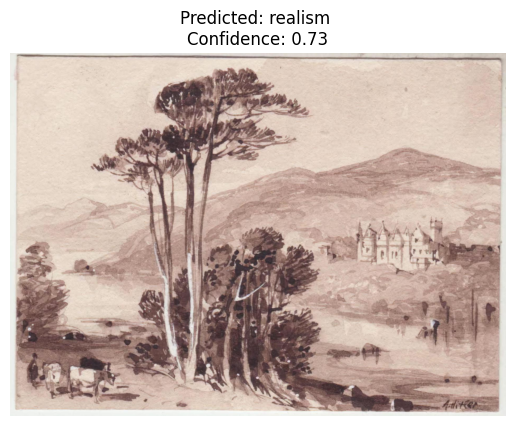

Prediction: realism, Confidence: 0.73


In [24]:
#correct prediction

# Test images
test_image_path = "/kaggle/input/images-8classes/wikiart-target_style-class_8-keepgenre_True-merge_style_m1-flat_False/wikiart-target_style-class_8-keepgenre_True-merge_style_m1-flat_False/test/realism/realism_adolf-hitler_the-castle-on-the-donau.jpg"
predicted_class, confidence = predict_image(test_image_path)
print(f"Prediction: {predicted_class}, Confidence: {confidence:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


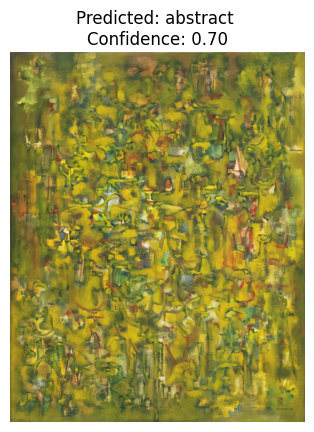

Prediction: abstract, Confidence: 0.70


In [26]:
#correct prediction
# Test images
test_image_path = "/kaggle/input/images-8classes/wikiart-target_style-class_8-keepgenre_True-merge_style_m1-flat_False/wikiart-target_style-class_8-keepgenre_True-merge_style_m1-flat_False/test/abstract/abstract-expressionism_ad-reinhardt_number-43-abstract-painting-yellow-1947.jpg"
predicted_class, confidence = predict_image(test_image_path)
print(f"Prediction: {predicted_class}, Confidence: {confidence:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


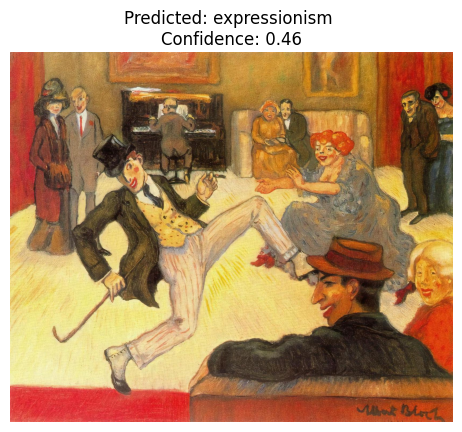

Prediction: expressionism, Confidence: 0.46


In [29]:
#correct prediction
# Test images
test_image_path = "/kaggle/input/images-8classes/wikiart-target_style-class_8-keepgenre_True-merge_style_m1-flat_False/wikiart-target_style-class_8-keepgenre_True-merge_style_m1-flat_False/test/expressionism/expressionism_albert-bloch_the-dancer-ragtime-1911.jpg"
predicted_class, confidence = predict_image(test_image_path)
print(f"Prediction: {predicted_class}, Confidence: {confidence:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


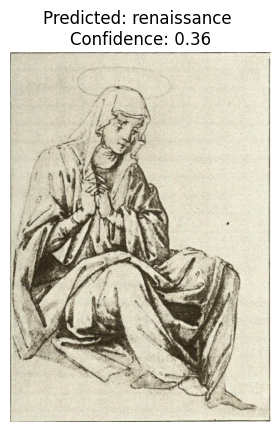

Prediction: renaissance, Confidence: 0.36


In [34]:
#correct prediction
# Test images
test_image_path = "/kaggle/input/images-8classes/wikiart-target_style-class_8-keepgenre_True-merge_style_m1-flat_False/wikiart-target_style-class_8-keepgenre_True-merge_style_m1-flat_False/test/renaissance/early-renaissance_andrea-del-castagno_mary-seated-under-the-cross.jpg"
predicted_class, confidence = predict_image(test_image_path)
print(f"Prediction: {predicted_class}, Confidence: {confidence:.2f}")


# **Wrong Prediction**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


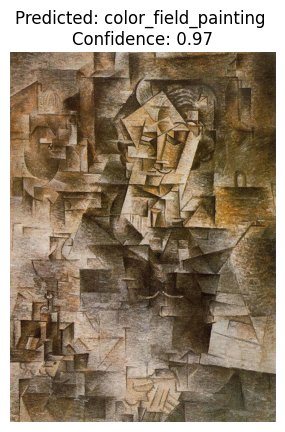

Prediction: color_field_painting, Confidence: 0.97


In [35]:
#WRONG prediction
# Test images
test_image_path = "/kaggle/input/images-8classes/wikiart-target_style-class_8-keepgenre_True-merge_style_m1-flat_False/wikiart-target_style-class_8-keepgenre_True-merge_style_m1-flat_False/test/cubism/analytical-cubism_pablo-picasso_portrait-of-daniel-henry-kahnweiler-1910.jpg"
predicted_class, confidence = predict_image(test_image_path)
print(f"Prediction: {predicted_class}, Confidence: {confidence:.2f}")
